## Face and Facial Keypoint detection

After we have trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input. So, to detect any face using the neural network, we will have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that our net expects. This step will be similar to the `data_transform` applied in the previous Define the CNN Architecture Notebook, to rescale, normalize, and turn any image into a Tensor to be accepted as input to the CNN.
3. Use the trained model to detect facial keypoints on the image.

In the next python cell we load in required libraries for this section of the project.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on. Any image of faces in the `images/` directory can be selected.

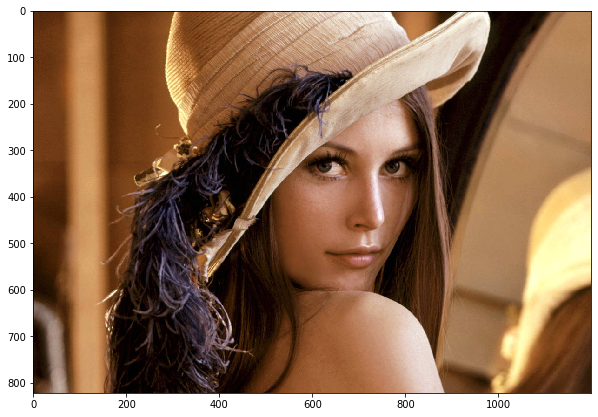

In [126]:
import cv2
# load in color image for face detection
image = cv2.imread(r"images/Lena.jpg")

# By default, OpenCV load an image in BGR format.
# So we need to switch red and blue color channels 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

## Detect all faces in an image

Next, we will use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). 

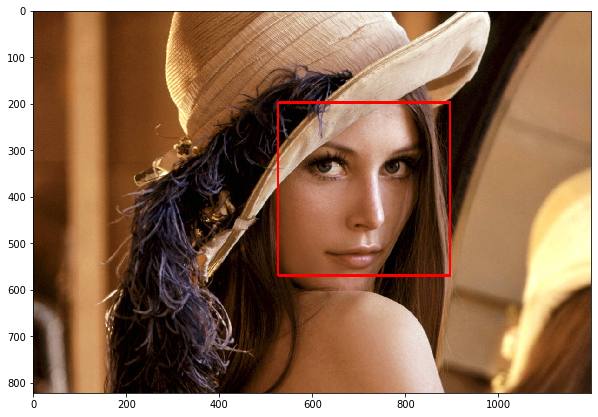

In [127]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
#face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_mcs_nose.xml')
#face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_smile.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(10,10))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [128]:
import torch
from models import Net

net = Net()

## load the best saved model parameters (by your path name)
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=9216, out_features=1000, bias=True)
  (lin2): Linear(in_features=1000, out_features=1000, bias=True)
  (lin3): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

We will need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for our network to see as input, you'll wrap that Tensor in a Variable() and can apply the `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and we may find it helpful to write a helper function like `show_keypoints`. We should end up with an image that closely match the facial features on each individual face.

(822, 1200, 3)


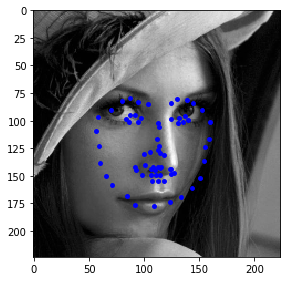

In [129]:
image_copy = np.copy(image)
print(image_copy.shape)

# loop over the detected faces from the haar cascade
for i, (x,y,w,h) in enumerate(faces):
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(2, len(faces), i+1)
    
    wpad = int(w*0.2)
    hpad = int(h*0.2)
    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-hpad:y+h+hpad, x-wpad:x+w+wpad]

    ## Convert the face region from RGB to grayscale
    #if len(image_copy.shape)==3:
    roi_copy = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi_copy = roi_copy/255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi_copy = cv2.resize(roi_copy, (224, 224))
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi_tensor = torch.from_numpy(roi_copy.reshape(1,1,224,224))
    
    # convert images to FloatTensors
    roi_tensor = roi_tensor.type(torch.FloatTensor)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    output_pts = net(roi_tensor)

    ## TODO: Display each detected face and the corresponding keypoints        
    # process the predicted key_pts data
    torch.squeeze(output_pts) # remove the batch dim
    output_pts = output_pts.view(68, -1)
    predicted_key_pts = output_pts.data.numpy()

    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*50.0+100
    
    plt.imshow(roi_copy, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=60, marker='.', c='b')
        
plt.show()